
# Deep Learning Homework 6 (Spring 2023)

This code is provided for Deep Learning class (601.482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, Keith Harrigian, and Yiqing Shen.


### Imports

In [44]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounting Failed.


In [45]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Problem 1: Unsupervised Pre-training

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

Dataset is available at: https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/yshen92_jh_edu/EcTxWAXsAhtDiv3vUxCTF8gBgAARCUvvKthb3s-pEExyMg

In [46]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

### Data Paths

In [47]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "./HW6_data"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [48]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
])

tensor_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):

    """
    ImageDataset
    """

    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=tensor_transform):
        """
        ##TODO: Add support for colorization dataset

        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
            elif self.op == 'train_cor':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'val_cor':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """

        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """

        """

        if self.op == "train_cor" or self.op == "val_cor":
            gray_img_name = str(idx) + '_gray.jpg'
            img_name = str(idx) + '_input.jpg'
            gray_img = io.imread(os.path.join(self.data_dir, str(idx), gray_img_name))
            img = io.imread(os.path.join(self.data_dir, str(idx), img_name))

            gray_img = np.stack((gray_img,)*3, axis=-1)
            if self.transform:
                gray_img, img = self.img_transform(gray_img, img)
            return gray_img, img
        else:
            ## Load Image and Parse Properties
            img_name = str(idx) + '_input.jpg'
            mask_name = str(idx) + '_mask.png'
            img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
            mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
            if len(mask.shape) == 2:
                h, w  = mask.shape
            elif len(mask.shape) == 3:
                h, w, c = mask.shape
            ## Convert grey-scale label to one-hot encoding
            new_mask = np.zeros((h, w, self.mask_num))
            for idx in range(self.mask_num):
                #if the mask has 3 dimension use this code
                new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
                #if the mask has 1 dimension use the code below
                #new_mask[:, :, idx] = mask == self.mask_value[idx]
            ## Transform image and mask
            if self.transform:
                img, mask = self.img_transform(img, new_mask)
            # ## Use dictionary to output
            # sample = {'img': img, 'mask': mask}
            # return sample
            return img, mask

    def img_transform(self,
                      img,
                      mask):
        """

        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [49]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """

    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """

    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):

    """

    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        self.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations

        out = self.out_conv(conv1m_out)
        out = torch.sigmoid(out)

        return out


### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [50]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes

      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    assert prediction.shape[0] == 1 #This line can not be deleted
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    dice_classes = np.zeros(n_classes)

    prediction_one_hot = functional.one_hot(prediction.squeeze(0).to(torch.int64), num_classes=n_classes)  # [256, 320, n_classes]
    prediction_one_hot = prediction_one_hot.permute(2, 0, 1).unsqueeze(0)  # [1, n_classes, 256, 320]

    for cl in range(n_classes):
        pred_flat = prediction_one_hot[:, cl].view(-1).float()
        target_flat = target[:, cl].view(-1).float()

        TP = (pred_flat * target_flat).sum()
        FP = (pred_flat * (1 - target_flat)).sum()
        FN = ((1 - pred_flat) * target_flat).sum()

        #When there is no ground truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0,
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        if target_flat.sum() == 0:
            dice_classes[cl] = 1 if FP == 0 else 0
        else:
            dice_classes[cl] = (2. * TP) / (2. * TP + FP + FN)
        
    return dice_classes.mean()



def dice_score_dataset(model, dataloader, num_classes, use_gpu=True):
    """
    Compute the mean dice score on a set of data.

    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.

    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does

    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes

    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]

        prediction = torch.argmax(out, dim = 1)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
        img.cpu()
        target.cpu()

    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


## TODO: Implement DICE loss,
#  It should conform to to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self, num_classes, eps=1e-5):
        super(DICELoss, self).__init__()
        self.num_classes = num_classes
        self.eps = eps

    def forward(self, prediction, target):
        dice_classes = torch.zeros(self.num_classes, device=prediction.device)

        for cl in range(self.num_classes):
            pred_cl = prediction[:, cl].contiguous().view(-1).float()
            target_cl = target[:, cl].contiguous().view(-1).float()

            inter = (pred_cl * target_cl).sum()
            union = pred_cl.sum() + target_cl.sum() + self.eps
            dice_classes[cl] = (2. * inter) / union

        dice_loss = 1 - dice_classes.mean()

        return dice_loss

## Training Procedure (Segmentation)

In [51]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [52]:
## Initialize your unet
n_classes = 6

model = UNET(n_classes, useBN=True)
model.to(device)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=tensor_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=tensor_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=tensor_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = DICELoss(num_classes=n_classes)

early_stopper = EarlyStopper(patience=5)

trainLoss = []
valLoss = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model.train()
    train_loss = 0.0

    for input, label in train_dataloader:
        input = input.cuda()
        label = label.cuda()

        optimizer.zero_grad()

        output = model(input)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        input = input.cpu()
        label = label.cpu()
    
    scheduler.step()
    train_loss /= len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss}")
    trainLoss.append(train_loss)

    ########################### Validation #####################################
    # TODO: Design your own validation section

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, label in validation_dataloader:
            input = input.cuda()
            label = label.cuda()

            output = model(input)
            val_loss += criterion(output, label).item()

            input = input.cpu()
            label = label.cpu()

        val_loss /= len(validation_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}")
        valLoss.append(val_loss) 

        if early_stopper.early_stop(val_loss): 
            break

        test_dice_score = dice_score_dataset(model, test_dataloader, n_classes)
        print(f"Test Dice Score: {test_dice_score}")

with torch.no_grad():
    test_dice_score = dice_score_dataset(model, test_dataloader, n_classes)
    print(f"Test Dice Score: {test_dice_score}")

Start Training...

EPOCH 1 of 200



Epoch 1/200 - Loss: 0.8027158141136169
Epoch 1/200 - Validation Loss: 0.8182910203933715
Test Dice Score: 0.6361238711762417

EPOCH 2 of 200

Epoch 2/200 - Loss: 0.7758870402971904
Epoch 2/200 - Validation Loss: 0.7670488715171814
Test Dice Score: 0.5453675719977279

EPOCH 3 of 200

Epoch 3/200 - Loss: 0.7551141917705536
Epoch 3/200 - Validation Loss: 0.7484448671340942
Test Dice Score: 0.5309287634764526

EPOCH 4 of 200

Epoch 4/200 - Loss: 0.7358107169469198
Epoch 4/200 - Validation Loss: 0.7292259097099304
Test Dice Score: 0.5164542794111184

EPOCH 5 of 200

Epoch 5/200 - Loss: 0.7100396613279979
Epoch 5/200 - Validation Loss: 0.7159976482391357
Test Dice Score: 0.5100061868069072

EPOCH 6 of 200

Epoch 6/200 - Loss: 0.6822066366672516
Epoch 6/200 - Validation Loss: 0.6939333081245422
Test Dice Score: 0.39670783711296587

EPOCH 7 of 200

Epoch 7/200 - Loss: 0.6633786678314209
Epoch 7/200 - Validation Loss: 0.671937894821167
Test Dice Score: 0.3921996264362436

EPOCH 8 of 200

Epoch 

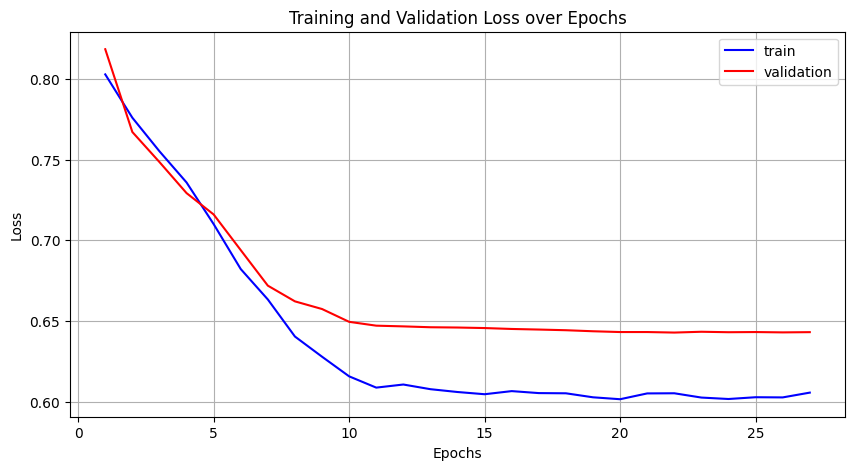

In [53]:
epochs = list(range(1, len(trainLoss)+1))

plt.figure(figsize=(10, 5))

plt.plot(epochs, trainLoss, label="Training Loss", color="blue")
plt.plot(epochs, valLoss, label="Validation Loss", color="red")

plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train', 'validation'])
plt.grid(True)

plt.show()

Start Training...

EPOCH 1 of 200

Epoch 1/200 - Loss: 0.8267921288808187
Epoch 1/200 - Validation Loss: 0.8264131426811219
Test Dice Score: 0.3139547096846703

EPOCH 2 of 200

Epoch 2/200 - Loss: 0.8129008114337921
Epoch 2/200 - Validation Loss: 0.816291344165802
Test Dice Score: 0.44629915733341474

EPOCH 3 of 200

Epoch 3/200 - Loss: 0.801466848452886
Epoch 3/200 - Validation Loss: 0.8259110569953918
Test Dice Score: 0.3358684212264295

EPOCH 4 of 200

Epoch 4/200 - Loss: 0.798098216454188
Epoch 4/200 - Validation Loss: 0.7944546580314636
Test Dice Score: 0.486943559604697

EPOCH 5 of 200

Epoch 5/200 - Loss: 0.7941338857014973
Epoch 5/200 - Validation Loss: 0.7977356553077698
Test Dice Score: 0.5353079243353568

EPOCH 6 of 200

Epoch 6/200 - Loss: 0.7893777231375376
Epoch 6/200 - Validation Loss: 0.7870543718338012
Test Dice Score: 0.5439378493449961

EPOCH 7 of 200

Epoch 7/200 - Loss: 0.7790600538253785
Epoch 7/200 - Validation Loss: 0.7790716409683227
Test Dice Score: 0.54118486

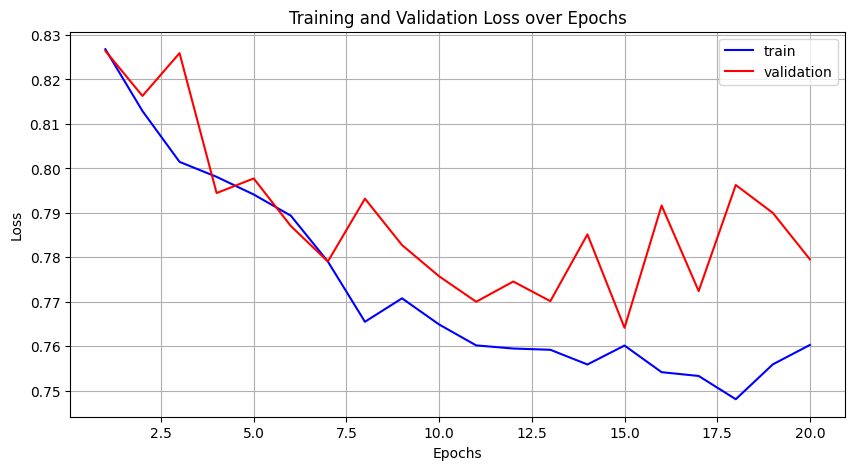

In [54]:
# 1b Apply data augmentation

## Initialize your unet
n_classes = 6
model.to(torch.device('cpu')) # move old model to cpu, freeing CUDA space
model_col = UNET(n_classes, useBN=True)
model_col.to(device)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model_col.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = DICELoss(num_classes=n_classes)

early_stopper = EarlyStopper(patience=5)

trainLoss = []
valLoss = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model_col.train()
    train_loss = 0.0

    for input, label in train_dataloader:
        input = input.cuda()
        label = label.cuda()

        optimizer.zero_grad()

        output = model_col(input)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        input = input.cpu()
        label = label.cpu()
    
    scheduler.step()
    train_loss /= len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss}")
    trainLoss.append(train_loss)

    ########################### Validation #####################################
    # TODO: Design your own validation section

    model_col.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, label in validation_dataloader:
            input = input.cuda()
            label = label.cuda()

            output = model_col(input)
            val_loss += criterion(output, label).item()

            input = input.cpu()
            label = label.cpu()

        val_loss /= len(validation_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}")
        valLoss.append(val_loss) 

        if early_stopper.early_stop(val_loss): 
            break

        test_dice_score = dice_score_dataset(model_col, test_dataloader, n_classes)
        print(f"Test Dice Score: {test_dice_score}")

with torch.no_grad():
    test_dice_score = dice_score_dataset(model_col, test_dataloader, n_classes)
    print(f"Test Dice Score: {test_dice_score}")


epochs = list(range(1, len(trainLoss)+1))

plt.figure(figsize=(10, 5))

plt.plot(epochs, trainLoss, label="Training Loss", color="blue")
plt.plot(epochs, valLoss, label="Validation Loss", color="red")

plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train', 'validation'])
plt.grid(True)

plt.show()

In [55]:
# Copied, need to modify later

for param in model_col.parameters():
    param.requires_grad = False
model_col.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)
model_col.to(device)
early_stopper = EarlyStopper(patience=5)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model_col.out_conv.parameters(),lr=learning_rate)
criterion = DICELoss(num_classes=n_classes)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
trainLoss_list_4 = []
valLoss_list_4 = []
print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model_col.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model_col(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_dataloader)}")
    trainLoss_list_4.append(running_loss/len(train_dataloader))
        
    model_col.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in validation_dataloader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model_col(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    val_loss /= len(validation_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}")
    valLoss_list_4.append(val_loss)
    if early_stopper.early_stop(val_loss): 
        break
with torch.no_grad():
    test_dice_score = dice_score_dataset(model_col, test_dataloader, n_classes)
    print(f"Test Dice Score: {test_dice_score}")

epochs = list(range(1,len(trainLoss_list_4)+1))

# Plotting
plt.figure(figsize=(10, 6))

# Plot the first set of accuracies
#for i in range(len(epochs)):
#    plt.plot(epochs[i], trainLoss_list[i], valLoss_list[i], color = 'r')1
plt.plot(trainLoss_list_4, color = 'blue')
plt.plot(valLoss_list_4, color = 'red')


# Setting title, labels, and other configurations
plt.title('train/validation losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.grid(True)

# Display the plot
plt.show()

Start Training...

EPOCH 1 of 200



RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

In [ ]:
col_train_dataset=ImageDataset(input_dir=colorization_data_dir, op="train_cor", mask_json_path=mask_json, transforms=tensor_transform)
col_validation_dataset=ImageDataset(input_dir=colorization_data_dir, op="val_cor", mask_json_path=mask_json, transforms=tensor_transform)

col_train_dataloader = DataLoader(col_train_dataset, batch_size=train_batch_size, shuffle=True)
col_validation_dataloader = DataLoader(col_validation_dataset, batch_size=validation_batch_size, shuffle=False)

Start Training...

EPOCH 1 of 200



Epoch 1/200 - Loss: 0.005290562069517965
Epoch 1/200 - Validation Loss: 0.0021959898062050343

EPOCH 2 of 200

Epoch 2/200 - Loss: 0.00124323388317061
Epoch 2/200 - Validation Loss: 0.0018141508800908924

EPOCH 3 of 200

Epoch 3/200 - Loss: 0.0010561587042965978
Epoch 3/200 - Validation Loss: 0.0020797418663278224

EPOCH 4 of 200

Epoch 4/200 - Loss: 0.0009613981918554824
Epoch 4/200 - Validation Loss: 0.0013448689598590136

EPOCH 5 of 200

Epoch 5/200 - Loss: 0.0008916557051165252
Epoch 5/200 - Validation Loss: 0.0016418765066191555

EPOCH 6 of 200

Epoch 6/200 - Loss: 0.000827516592400582
Epoch 6/200 - Validation Loss: 0.0017221907852217554

EPOCH 7 of 200

Epoch 7/200 - Loss: 0.0007587300702115322
Epoch 7/200 - Validation Loss: 0.0014667055103927851

EPOCH 8 of 200

Epoch 8/200 - Loss: 0.0007247084681436701
Epoch 8/200 - Validation Loss: 0.0017459526658058166

EPOCH 9 of 200

Epoch 9/200 - Loss: 0.000658033038606668
Epoch 9/200 - Validation Loss: 0.002196617634035647


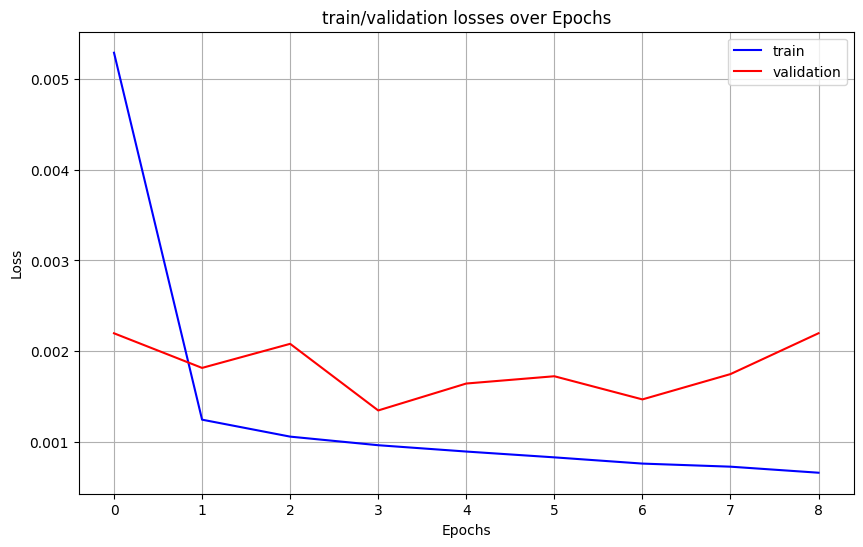

In [ ]:
## Initialize your unet
n_classes = 6
model_col = UNET(n_classes, useBN=True)
model_col.out_conv = nn.Conv2d(32, 3, kernel_size=1)
model_col.to(device)
early_stopper = EarlyStopper(patience=5)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model_col.parameters(),lr=learning_rate)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
trainLoss = []
valLoss = []
print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model_col.train()
    running_loss = 0.0

    for input, label in col_train_dataloader:
        input = input.cuda()
        label = label.cuda()
        
        #print("inputs: ", inputs.size())
        #print("labels: ", labels.size())
        optimizer.zero_grad()
        
        output = model_col(input)
        
        #print("outputs: ", outputs.size())
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        input = input.cpu()
        label = label.cpu()
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(col_train_dataloader)}")
    trainLoss.append(running_loss/len(col_train_dataloader))
        
    model_col.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, label in col_validation_dataloader:
            input = input.cuda()
            label = label.cuda()

            output = model_col(input)
            val_loss += criterion(output, label).item()

            input = input.cpu()
            label = label.cpu()

    val_loss /= len(col_validation_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}")
    valLoss.append(val_loss)
    if early_stopper.early_stop(val_loss): 
        break

epochs = list(range(1,len(trainLoss)+1))
# Plotting
plt.figure(figsize=(10, 6))

# Plot the first set of accuracies
#for i in range(len(epochs)):
#    plt.plot(epochs[i], trainLoss_list[i], valLoss_list[i], color = 'r')1
plt.plot(trainLoss, color = 'blue')
plt.plot(valLoss, color = 'red')


# Setting title, labels, and other configurations
plt.title('train/validation losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.grid(True)

# Display the plot
plt.show()

# Problem 2: Transfer Learning

### Imports

In [ ]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

### Data Loading

In [ ]:
## Specify Batch Size
train_batch_size = 32
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.